In [1]:
from matplotlib.pyplot import get
import numpy as np
import pandas as pd
import sys
import os
import pickle
import csv
import ipdb
from tqdm import tqdm
from collections import OrderedDict, defaultdict
# import random

from training.utils import load_obj, save_obj
from training.data import load_data
from training.dataset import _preprocess_call_data, preprocess_and_make_dataset

from training.modelling.metrics import F1, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

np.random.seed(1)

CONFIG = {
    'pilot_data': 'feb16-mar15_data',
    'current_week': 11,
    'week': 'week11'
}
T = 12

calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621']


2021-10-11 11:45:19,386 - INFO - _init_num_threads - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-11 11:45:19,387 - INFO - _init_num_threads - NumExpr defaulting to 8 threads.
2021-10-11 11:45:22,428 - DEBUG - <module> - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2021-10-11 11:45:22,732 - DEBUG - <module> - Creating converter from 7 to 5
2021-10-11 11:45:22,733 - DEBUG - <module> - Creating converter from 5 to 7
2021-10-11 11:45:22,733 - DEBUG - <module> - Creating converter from 7 to 5
2021-10-11 11:45:22,734 - DEBUG - <module> - Creating converter from 5 to 7


In [2]:
# pilot_beneficiary_data, pilot_call_data = load_data(CONFIG['pilot_data'])
# pilot_call_data = _preprocess_call_data(pilot_call_data)

complete_group = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')
all_user_ids = complete_group['user_id'].to_list()
rmab_group = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
round_robin_group = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

arm_dict = {}
for user_id in rmab_user_ids:
    arm_dict[user_id] = 'rmab'
for user_id in round_robin_user_ids:
    arm_dict[user_id] = 'round_robin'

with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

intervention_dict = {}
group_cluster_size = defaultdict(lambda: defaultdict(lambda: 0))
for file in calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            curr_cluster = complete_group[complete_group['user_id'] == user_id]['cluster'].item()
            if user_id not in intervention_dict:
                intervention_dict[user_id] = [int(file.split('_')[1][4:])]
            else:
                intervention_dict[user_id].append(int(file.split('_')[1][4:]))
            if user_id in rmab_user_ids:
                group_cluster_size['rmab'][curr_cluster] += 1
            elif user_id in round_robin_user_ids:
                group_cluster_size['round_robin'][curr_cluster] += 1

rmab_cluster_list = [(group_cluster_size['rmab'][cluster], cluster) for cluster in range(40)]
round_robin_cluster_list = [(group_cluster_size['round_robin'][cluster], cluster) for cluster in range(40)]

rmab_cluster_list = sorted(rmab_cluster_list, reverse=True)[:5]
round_robin_cluster_list = sorted(round_robin_cluster_list, reverse=True)[:5]

top_cluster_list = {'rmab': rmab_cluster_list, 'round_robin': round_robin_cluster_list}



/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [134]:
predicted_clusters = cls.predict(pilot_static_features)


In [135]:
predicted_pilot_probs = cluster_transition_probabilities.set_index('cluster').loc[predicted_clusters]
predicted_pilot_probs = predicted_pilot_probs.reset_index()
predicted_pilot_probs['user_id'] = pilot_user_ids
predicted_pilot_probs

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)",user_id
0,3,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453,2385611
1,35,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236,2385612
2,3,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453,2385613
3,35,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236,2385614
4,27,169.0,0.777778,0.222222,0.388889,0.611111,0.284938,0.715062,0.235178,0.764822,2385615
...,...,...,...,...,...,...,...,...,...,...,...
23003,28,102.0,0.700000,0.300000,0.615385,0.384615,0.458232,0.541768,0.379988,0.620012,2409132
23004,35,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236,2409133
23005,26,65.0,0.857143,0.142857,0.750000,0.250000,0.714614,0.285386,0.664207,0.335793,2409134
23006,10,304.0,0.152199,0.847801,0.142857,0.857143,0.000000,1.000000,0.032706,0.967294,2409135


In [136]:
import matplotlib.pyplot as plt

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
colors = pd.DataFrame({'color':[get_cmap(40)(i) for i in range(40)],
                       'cluster': list(range(40))})

predicted_pilot_probs = pd.merge(colors, predicted_pilot_probs, how='right').set_index('user_id').loc[predicted_pilot_probs.user_id].reset_index()
predicted_pilot_probs

,user_id,color,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,2385611,"(1.0, 0.45432737740430046, 0.0, 1.0)",3,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453
1,2385612,"(1.0, 0.0, 0.699519836539067, 1.0)",35,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236
2,2385613,"(1.0, 0.45432737740430046, 0.0, 1.0)",3,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453
3,2385614,"(1.0, 0.0, 0.699519836539067, 1.0)",35,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236
4,2385615,"(0.08894049038279797, 0.0, 1.0, 1.0)",27,169.0,0.777778,0.222222,0.388889,0.611111,0.284938,0.715062,0.235178,0.764822
...,...,...,...,...,...,...,...,...,...,...,...,...
23003,2409132,"(0.24038294951756495, 0.0, 1.0, 1.0)",28,102.0,0.700000,0.300000,0.615385,0.384615,0.458232,0.541768,0.379988,0.620012
23004,2409133,"(1.0, 0.0, 0.699519836539067, 1.0)",35,440.0,0.250000,0.750000,0.142857,0.857143,0.000000,1.000000,0.093764,0.906236
23005,2409134,"(0.0, 0.06250196875196867, 1.0, 1.0)",26,65.0,0.857143,0.142857,0.750000,0.250000,0.714614,0.285386,0.664207,0.335793
23006,2409135,"(0.4855754086523317, 1.0, 0.0, 1.0)",10,304.0,0.152199,0.847801,0.142857,0.857143,0.000000,1.000000,0.032706,0.967294


In [14]:
transitions_df = pd.read_csv('outputs/pilot_transitions.csv')
transitions_df

,Unnamed: 0,user_id,pre-action state,action,post-action state
0,0,2394384,H,No Intervention,L
1,1,2394384,L,Intervention,L
2,2,2394384,L,No Intervention,L
3,3,2394384,L,No Intervention,L
4,4,2394384,L,No Intervention,L
...,...,...,...,...,...
253028,253028,2390819,L,No Intervention,L
253029,253029,2390819,L,No Intervention,L
253030,253030,2390819,L,No Intervention,L
253031,253031,2390819,L,No Intervention,L


In [63]:
def get_transition_probabilities(beneficiaries, transitions, min_support=1):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}


In [64]:
user_probs, sup = get_transition_probabilities([pilot_user_ids[0]], transitions_df)



In [65]:
all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm(pilot_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], transitions_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23008/23008 [03:12<00:00, 119.49it/s]


In [138]:
all_probs = pd.merge(all_probs, predicted_pilot_probs[['user_id', 'color']],
                     on='user_id', how='left')
all_probs

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",color
0,2385611.0,1.0,0.0,NaN,NaN,0.888889,0.111111,1.000000,0.000000,"(1.0, 0.45432737740430046, 0.0, 1.0)"
1,2385612.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,"(1.0, 0.0, 0.699519836539067, 1.0)"
2,2385613.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.100000,0.900000,"(1.0, 0.45432737740430046, 0.0, 1.0)"
3,2385614.0,0.0,1.0,NaN,NaN,0.500000,0.500000,0.250000,0.750000,"(1.0, 0.0, 0.699519836539067, 1.0)"
4,2385615.0,1.0,0.0,NaN,NaN,1.000000,0.000000,NaN,NaN,"(0.08894049038279797, 0.0, 1.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...
23003,2409132.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,"(0.24038294951756495, 0.0, 1.0, 1.0)"
23004,2409133.0,1.0,0.0,NaN,NaN,0.900000,0.100000,NaN,NaN,"(1.0, 0.0, 0.699519836539067, 1.0)"
23005,2409134.0,NaN,NaN,NaN,NaN,0.400000,0.600000,0.500000,0.500000,"(0.0, 0.06250196875196867, 1.0, 1.0)"
23006,2409135.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.222222,0.777778,"(0.4855754086523317, 1.0, 0.0, 1.0)"


In [50]:
## support 10
from sklearn.metrics import mean_squared_error
for col in range(8):
    x = all_probs.iloc[:, 1:].iloc[:, col]
    y = predicted_pilot_probs.iloc[:, 2:-1].iloc[:, col]
    try:
        print(all_probs.iloc[:, 1:].columns[col],
          'non nan vals:', x.values[~x.isna()].shape,
          np.sqrt(mean_squared_error(x.values[~x.isna()], y.values[~x.isna()])))
    except:
        print(all_probs.iloc[:, 1:].columns[col],
          'non nan vals:', x.values[~x.isna()].shape)

P(L, I, L) non nan vals: (0,)
P(L, I, H) non nan vals: (0,)
P(H, I, L) non nan vals: (0,)
P(H, I, H) non nan vals: (0,)
P(L, N, L) non nan vals: (4927,) 0.7559580186135715
P(L, N, H) non nan vals: (4927,) 0.7559580186135715
P(H, N, L) non nan vals: (7688,) 0.2844931794027929
P(H, N, H) non nan vals: (7688,) 0.2844931794027929


In [46]:
## suport 5
from sklearn.metrics import mean_squared_error
for col in range(8):
    x = all_probs.iloc[:, 1:].iloc[:, col]
    y = predicted_pilot_probs.iloc[:, 2:-1].iloc[:, col]
    try:
        print(all_probs.iloc[:, 1:].columns[col],
          'non nan vals:', x.values[~x.isna()].shape,
          np.sqrt(mean_squared_error(x.values[~x.isna()], y.values[~x.isna()])))
    except:
        print(all_probs.iloc[:, 1:].columns[col],
          'non nan vals:', x.values[~x.isna()].shape)

P(L, I, L) non nan vals: (0,)
P(L, I, H) non nan vals: (0,)
P(H, I, L) non nan vals: (0,)
P(H, I, H) non nan vals: (0,)
P(L, N, L) non nan vals: (10798,) 0.6593769941622158
P(L, N, H) non nan vals: (10798,) 0.6593769941622158
P(H, N, L) non nan vals: (13904,) 0.28126575592081765
P(H, N, H) non nan vals: (13904,) 0.28126575592081765


In [41]:
## suport 3
from sklearn.metrics import mean_squared_error
for col in range(8):
    x = all_probs.iloc[:, 1:].iloc[:, col]
    y = predicted_pilot_probs.iloc[:, 2:-1].iloc[:, col]
    print(all_probs.iloc[:, 1:].columns[col],
          'non nan vals:', x.values[~x.isna()].shape,
          np.sqrt(mean_squared_error(x.values[~x.isna()], y.values[~x.isna()])))

P(L, I, L) non nan vals: (51,) 0.22106999760090493
P(L, I, H) non nan vals: (51,) 0.22106999760090493
P(H, I, L) non nan vals: (62,) 0.6836421197624968
P(H, I, H) non nan vals: (62,) 0.6836421197624968
P(L, N, L) non nan vals: (13251,) 0.6186837717932147
P(L, N, H) non nan vals: (13251,) 0.6186837717932147
P(H, N, L) non nan vals: (15977,) 0.3213008916845135
P(H, N, H) non nan vals: (15977,) 0.3213008916845135


In [37]:
## support 1
from sklearn.metrics import mean_squared_error
for col in range(8):
    x = all_probs.iloc[:, 1:].iloc[:, col]
    y = predicted_pilot_probs.iloc[:, 2:-1].iloc[:, col]
    print(all_probs.iloc[:, 1:].columns[col],
          'non nan vals:', x.values[~x.isna()].shape,
          np.sqrt(mean_squared_error(x.values[~x.isna()], y.values[~x.isna()])))

P(L, I, L) non nan vals: (2728,) 0.5983368727338593
P(L, I, H) non nan vals: (2728,) 0.5983368727338593
P(H, I, L) non nan vals: (2729,) 0.5419969502630368
P(H, I, H) non nan vals: (2729,) 0.5419969502630368
P(L, N, L) non nan vals: (16959,) 0.58083997650388
P(L, N, H) non nan vals: (16959,) 0.58083997650388
P(H, N, L) non nan vals: (19134,) 0.42303562670821626
P(H, N, H) non nan vals: (19134,) 0.42303562670821626


In [140]:
predicted_pilot_probs['color']

0        (1.0, 0.45432737740430046, 0.0, 1.0)
1          (1.0, 0.0, 0.699519836539067, 1.0)
2        (1.0, 0.45432737740430046, 0.0, 1.0)
3          (1.0, 0.0, 0.699519836539067, 1.0)
4        (0.08894049038279797, 0.0, 1.0, 1.0)
                         ...                 
23003    (0.24038294951756495, 0.0, 1.0, 1.0)
23004      (1.0, 0.0, 0.699519836539067, 1.0)
23005    (0.0, 0.06250196875196867, 1.0, 1.0)
23006     (0.4855754086523317, 1.0, 0.0, 1.0)
23007     (0.0, 0.5168293461562691, 1.0, 1.0)
Name: color, Length: 23008, dtype: object

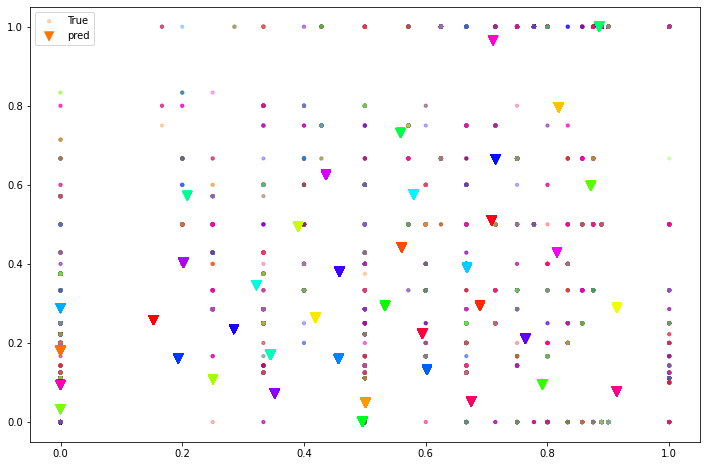

In [147]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
valid_bool = ~all_probs['P(L, N, L)'].isna() & \
             ~all_probs['P(H, N, L)'].isna()

plt.scatter(all_probs[valid_bool]['P(L, N, L)'],
            all_probs[valid_bool]['P(H, N, L)'],
            s=10, c=all_probs[valid_bool]['color'],
            label='True', alpha=0.3)
plt.scatter(predicted_pilot_probs[valid_bool]['P(E, A, E)'],
            predicted_pilot_probs[valid_bool]['P(NE, A, E)'],
            s=80, c=all_probs[valid_bool]['color'],
            label='pred',marker='v', alpha=1)

plt.legend()

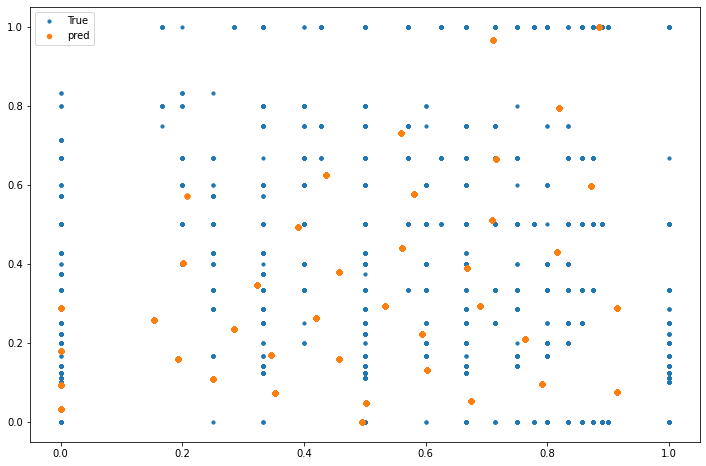

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
valid_bool = ~all_probs['P(L, N, L)'].isna() & \
             ~all_probs['P(H, N, L)'].isna()
colors = 
plt.scatter(all_probs[valid_bool]['P(L, N, L)'],
            all_probs[valid_bool]['P(H, N, L)'],
            s=10, label='True', alpha=1)
plt.scatter(predicted_pilot_probs[valid_bool]['P(E, A, E)'],
            predicted_pilot_probs[valid_bool]['P(NE, A, E)'],
            s=20, label='pred', alpha=1)

plt.legend()

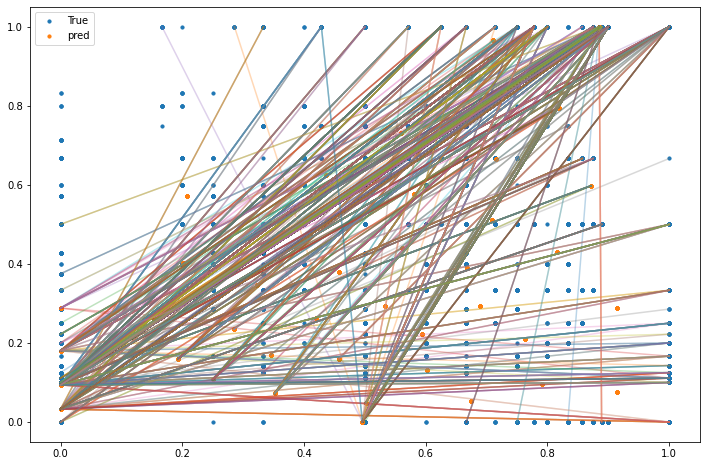

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
valid_bool = ~all_probs['P(L, N, L)'].isna() & \
             ~all_probs['P(H, N, L)'].isna()

plt.scatter(all_probs[valid_bool]['P(L, N, L)'],
            all_probs[valid_bool]['P(H, N, L)'],
            s=10, label='True', alpha=1)
plt.scatter(predicted_pilot_probs[valid_bool]['P(E, A, E)'],
            predicted_pilot_probs[valid_bool]['P(NE, A, E)'],
            s=10, label='pred', alpha=1)


p1_x = all_probs[valid_bool]['P(L, N, L)'].values
p1_y = all_probs[valid_bool]['P(H, N, L)'].values
# p1 = list(zip(p1_x, p1_y))
p2_x = predicted_pilot_probs[valid_bool]['P(E, A, E)'].values
p2_y = predicted_pilot_probs[valid_bool]['P(NE, A, E)'].values
# p2 = list(zip(p2_x, p2_y))
    
for j in range(len(p1_x)):
    if ((p1_x[j]-p2_x[j])**2 + (p1_y[j]-p2_y[j])**2)**0.5>1:
        plt.plot([p1_x[j], p2_x[j]], [p1_y[j], p2_y[j]], alpha=0.3)
#     if j>=50:
#         break
plt.legend()